In [375]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from usearch.index import search, MetricKind, Matches, BatchMatches
# from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.exceptions import NotFittedError
from sklearn.metrics import mean_squared_error as mse

In [376]:
# We will be using mtcars dataset
data = pd.read_csv('https://github.com/dvasiliu/AAML/blob/main/Data%20Sets/mtcars.csv?raw=True')
data

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


In [377]:
# We will be having multiple features - cyl, disp, hp, drat, wt, qsec, vs, am, gear, carb
X = data.drop(columns=['model', 'mpg']).values
y = data['mpg'].values

In [378]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_torch = torch.tensor(X_scaled, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

In [379]:
many_in_many: BatchMatches = search(X_scaled, X_scaled,len(X_scaled) , MetricKind.L2sq, exact=True)
one_in_many: Matches = search(X_scaled, X_scaled[0], len(X_scaled), MetricKind.L2sq, exact=True)

In [380]:
dist = one_in_many.to_list()
distances = cdist(X_scaled,X_scaled,metric='Euclidean')
distances.shape

(32, 32)

In [381]:
# Gaussian Kernel
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))

# Tricubic Kernel
def Tricubic(x):
  return np.where(np.abs(x)>1,0,(1-np.abs(x)**3)**3)

# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))

# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)

In [382]:
def kernel_function(d_ij,kern, tau):
    return kern(d_ij/(2*tau))

In [383]:
kern = Gaussian

In [384]:
weights = kernel_function(distances,kern,tau=0.05)
weights

array([[0.39894228, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.39894228, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.39894228, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.39894228, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.39894228,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.39894228]])

In [385]:
model = Ridge(alpha=0.001,max_iter=5000)

model.fit(np.diag(weights[:,0])@X_scaled, np.diag(weights[:,0])@y)
model.predict(X_scaled[0].reshape(1,-1))

array([20.97295036])

In [386]:
y[0]

21.0

In [387]:
# Implement Cauchy Kernel 
def Cauchy(x):
    return 1 / (1 + x**2)

In [388]:
def calculate_distances(x):
    return cdist(x, x, metric='Euclidean')

In [389]:
class ModelPipeline:
    def __init__(self, model_class, kernel, tau=0.15, param_grid=None):
        self.model_class = model_class
        self.kernel = kernel
        self.tau = tau
        self.param_grid = param_grid
        self.model = self.model_class(kernel=self.kernel, tau=self.tau)
        
        self.grid_search = None
        self.best_tau = None
        self.best_model = None

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
    
    def split_data(self, X, y, test_size=0.2, random_state=42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        return self.model.predict(self.X_test)

    def evaluate(self, y_pred):
        mean_squared_error = mse(self.y_test, y_pred)
        print(f"Mean Squared Error: {mean_squared_error}")
        return mean_squared_error

    def tune_parameters(self):
        if self.param_grid:
            self.grid_search = GridSearchCV(self.model_class(kernel=self.kernel), self.param_grid, scoring='neg_mean_squared_error', cv=5)
            self.grid_search.fit(self.X_train, self.y_train)
            self.best_tau = self.grid_search.best_params_['tau']
            print(f"Best tau: {self.best_tau}")
            self.best_model = self.model_class(kernel=self.kernel, tau=self.best_tau)
            self.best_model.fit(self.X_train, self.y_train)
        else:
            print("No param_grid provided")
    
    def predict_best_model(self):
        if self.best_model:
            return self.best_model.predict(self.X_test)
        else:
            raise ValueError("Best model not available")
    
    def evaluate_best_model(self, y_pred):
        best_mse = mse(self.y_test, y_pred)
        print(f"Optimized Mean Squared Error: {best_mse}")
        return best_mse
    
    def run_pipeline(self, X, y, tune=False):
        self.split_data(X, y)
        self.train_model()
        y_pred = self.predict()
        self.evaluate(y_pred)
        
        if tune and self.param_grid:
            self.tune_parameters()
            best_y_pred = self.predict_best_model()
            self.evaluate_best_model(best_y_pred)
        elif tune:
            print("No tuning parameters provided")


In [390]:
param_grid = {'tau': np.linspace(0.01, 0.5, 10)}
pipeline = ModelPipeline(Lowess, Cauchy, tau=0.15, param_grid=param_grid)
pipeline.run_pipeline(X_scaled, y, tune=True)

Mean Squared Error: 708.2549571475354
Best tau: 0.5
Optimized Mean Squared Error: 571.6161212691303


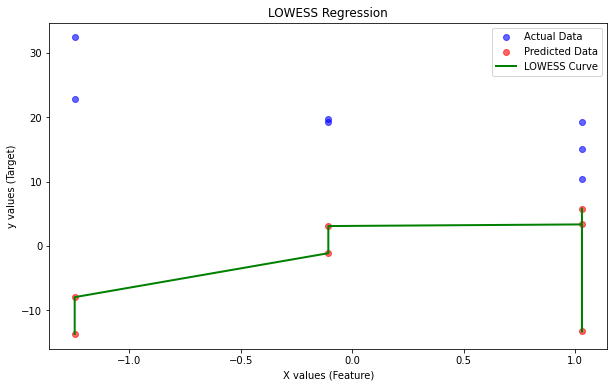

In [391]:
def plot_lowess_results(X_test, y_test, y_pred):
    if len(X_test.shape) > 1:
        X_test = X_test[:, 0]  

    plt.figure(figsize=(10, 6))

    plt.scatter(X_test, y_test, color='blue', label='Actual Data', alpha=0.6)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', alpha=0.6)

    sorted_idx = np.argsort(X_test)
    plt.plot(X_test[sorted_idx], y_pred[sorted_idx], color='green', linewidth=2, label='LOWESS Curve')

    plt.title('LOWESS Regression')
    plt.xlabel('X values (Feature)')
    plt.ylabel('y values (Target)')
    plt.legend()
    plt.show()

plot_lowess_results(X_test, y_test, y_pred)